In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tensorboardX import SummaryWriter

plt.ion()   # interactive mode
%matplotlib inline

Load Data
---------


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/UtkFace_Processed'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("total number of classes : ", len(class_names))

total number of classes :  62


### Visualize a few images


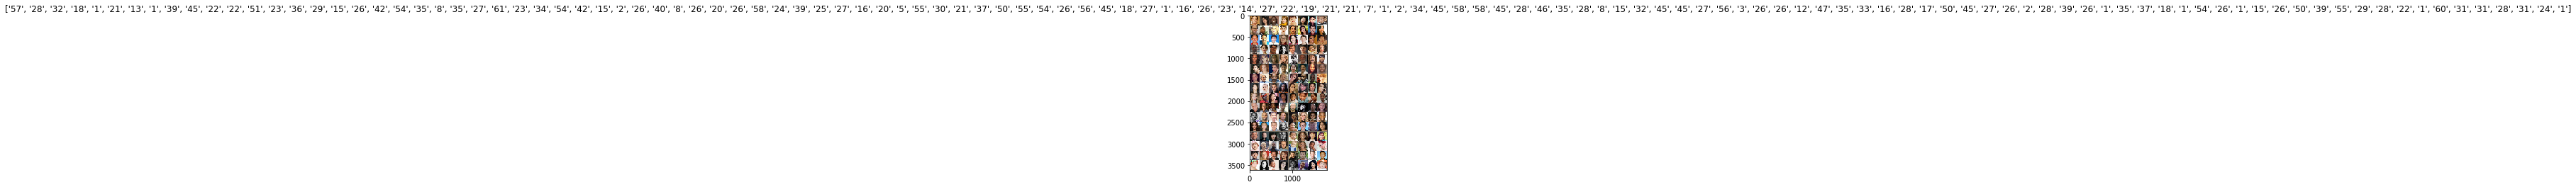

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [3]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, writer=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            five_error = 0
            ten_error = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                five_error += torch.sum(torch.abs(preds - labels.data) <=5 )
                ten_error += torch.sum(torch.abs(preds - labels.data) <=10 )

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f} Five: {:.4f} Ten: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, five_error.double() / dataset_sizes[phase], ten_error.double() / dataset_sizes[phase] ))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

writer = SummaryWriter('./logs/resnet50_full')


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer,
                       num_epochs=30)

Epoch 0/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:37<00:00,  3.06it/s]


train Loss: 3.5096 Acc: 0.1467 Five: 0.4273 Ten: 0.5997


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.15it/s]


val Loss: 3.1547 Acc: 0.1856 Five: 0.4869 Ten: 0.6637

Epoch 1/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:38<00:00,  3.02it/s]


train Loss: 3.0803 Acc: 0.1879 Five: 0.5119 Ten: 0.6921


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.22it/s]


val Loss: 2.9281 Acc: 0.2118 Five: 0.5541 Ten: 0.7351

Epoch 2/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:39<00:00,  2.99it/s]


train Loss: 2.8968 Acc: 0.2070 Five: 0.5502 Ten: 0.7351


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.33it/s]


val Loss: 2.7566 Acc: 0.2355 Five: 0.5849 Ten: 0.7677

Epoch 3/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:39<00:00,  3.00it/s]


train Loss: 2.7684 Acc: 0.2275 Five: 0.5800 Ten: 0.7591


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.01it/s]


val Loss: 2.6501 Acc: 0.2425 Five: 0.6059 Ten: 0.7845

Epoch 4/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:39<00:00,  3.01it/s]


train Loss: 2.6638 Acc: 0.2457 Five: 0.6019 Ten: 0.7797


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.06it/s]


val Loss: 2.5258 Acc: 0.2887 Five: 0.6395 Ten: 0.8064

Epoch 5/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:38<00:00,  3.02it/s]


train Loss: 2.5688 Acc: 0.2691 Five: 0.6218 Ten: 0.7982


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.03it/s]


val Loss: 2.4228 Acc: 0.2924 Five: 0.6362 Ten: 0.8134

Epoch 6/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:38<00:00,  3.03it/s]


train Loss: 2.4236 Acc: 0.3113 Five: 0.6575 Ten: 0.8239


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.12it/s]


val Loss: 2.3508 Acc: 0.3195 Five: 0.6679 Ten: 0.8312

Epoch 7/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:38<00:00,  3.03it/s]


train Loss: 2.4021 Acc: 0.3161 Five: 0.6608 Ten: 0.8264


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.23it/s]


val Loss: 2.3305 Acc: 0.3246 Five: 0.6712 Ten: 0.8335

Epoch 8/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:38<00:00,  3.03it/s]


train Loss: 2.3835 Acc: 0.3211 Five: 0.6634 Ten: 0.8274


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.14it/s]


val Loss: 2.3135 Acc: 0.3368 Five: 0.6796 Ten: 0.8382

Epoch 9/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:38<00:00,  3.02it/s]


train Loss: 2.3696 Acc: 0.3238 Five: 0.6641 Ten: 0.8267


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.16it/s]


val Loss: 2.3034 Acc: 0.3405 Five: 0.6870 Ten: 0.8405

Epoch 10/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:39<00:00,  3.00it/s]


train Loss: 2.3553 Acc: 0.3280 Five: 0.6706 Ten: 0.8316


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.09it/s]


val Loss: 2.2859 Acc: 0.3498 Five: 0.6842 Ten: 0.8410

Epoch 11/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:38<00:00,  3.01it/s]


train Loss: 2.3408 Acc: 0.3345 Five: 0.6744 Ten: 0.8358


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.12it/s]


val Loss: 2.2735 Acc: 0.3438 Five: 0.6931 Ten: 0.8484

Epoch 12/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:39<00:00,  3.00it/s]


train Loss: 2.3194 Acc: 0.3405 Five: 0.6787 Ten: 0.8399


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.06it/s]


val Loss: 2.2632 Acc: 0.3507 Five: 0.6819 Ten: 0.8391

Epoch 13/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:38<00:00,  3.02it/s]


train Loss: 2.3142 Acc: 0.3390 Five: 0.6790 Ten: 0.8383


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.21it/s]


val Loss: 2.2590 Acc: 0.3559 Five: 0.6936 Ten: 0.8484

Epoch 14/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:38<00:00,  3.02it/s]


train Loss: 2.3110 Acc: 0.3463 Five: 0.6812 Ten: 0.8403


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.10it/s]


val Loss: 2.2592 Acc: 0.3512 Five: 0.6922 Ten: 0.8442

Epoch 15/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:40<00:00,  2.97it/s]


train Loss: 2.3099 Acc: 0.3454 Five: 0.6807 Ten: 0.8397


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.15it/s]


val Loss: 2.2583 Acc: 0.3521 Five: 0.6866 Ten: 0.8405

Epoch 16/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:38<00:00,  3.01it/s]


train Loss: 2.3122 Acc: 0.3431 Five: 0.6798 Ten: 0.8395


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.13it/s]


val Loss: 2.2578 Acc: 0.3559 Five: 0.6926 Ten: 0.8461

Epoch 17/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:39<00:00,  2.99it/s]


train Loss: 2.3045 Acc: 0.3449 Five: 0.6796 Ten: 0.8412


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.28it/s]


val Loss: 2.2553 Acc: 0.3591 Five: 0.6950 Ten: 0.8493

Epoch 18/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:39<00:00,  3.00it/s]


train Loss: 2.3119 Acc: 0.3415 Five: 0.6778 Ten: 0.8380


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  4.97it/s]


val Loss: 2.2541 Acc: 0.3563 Five: 0.6931 Ten: 0.8475

Epoch 19/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:40<00:00,  2.98it/s]


train Loss: 2.3059 Acc: 0.3467 Five: 0.6835 Ten: 0.8434


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:07<00:00,  4.67it/s]


val Loss: 2.2565 Acc: 0.3577 Five: 0.6978 Ten: 0.8475

Epoch 20/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:40<00:00,  2.98it/s]


train Loss: 2.3065 Acc: 0.3463 Five: 0.6816 Ten: 0.8416


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.10it/s]


val Loss: 2.2562 Acc: 0.3554 Five: 0.6880 Ten: 0.8438

Epoch 21/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:39<00:00,  3.00it/s]


train Loss: 2.3032 Acc: 0.3448 Five: 0.6803 Ten: 0.8408


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.33it/s]


val Loss: 2.2566 Acc: 0.3549 Five: 0.6880 Ten: 0.8442

Epoch 22/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:38<00:00,  3.02it/s]


train Loss: 2.3066 Acc: 0.3457 Five: 0.6833 Ten: 0.8434


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.00it/s]


val Loss: 2.2564 Acc: 0.3563 Five: 0.6922 Ten: 0.8456

Epoch 23/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:39<00:00,  3.00it/s]


train Loss: 2.3080 Acc: 0.3460 Five: 0.6831 Ten: 0.8420


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.11it/s]


val Loss: 2.2531 Acc: 0.3535 Five: 0.6847 Ten: 0.8433

Epoch 24/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:38<00:00,  3.02it/s]


train Loss: 2.3064 Acc: 0.3438 Five: 0.6833 Ten: 0.8410


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:07<00:00,  4.70it/s]


val Loss: 2.2542 Acc: 0.3633 Five: 0.6931 Ten: 0.8465

Epoch 25/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:40<00:00,  2.98it/s]


train Loss: 2.3019 Acc: 0.3446 Five: 0.6862 Ten: 0.8419


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.16it/s]


val Loss: 2.2557 Acc: 0.3568 Five: 0.6945 Ten: 0.8484

Epoch 26/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:39<00:00,  3.00it/s]


train Loss: 2.3078 Acc: 0.3436 Five: 0.6815 Ten: 0.8412


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.20it/s]


val Loss: 2.2594 Acc: 0.3582 Five: 0.6964 Ten: 0.8498

Epoch 27/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:39<00:00,  2.98it/s]


train Loss: 2.3011 Acc: 0.3436 Five: 0.6803 Ten: 0.8399


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.11it/s]


val Loss: 2.2565 Acc: 0.3568 Five: 0.6898 Ten: 0.8470

Epoch 28/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:38<00:00,  3.03it/s]


train Loss: 2.3042 Acc: 0.3491 Five: 0.6858 Ten: 0.8459


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.23it/s]


val Loss: 2.2545 Acc: 0.3568 Five: 0.6945 Ten: 0.8465

Epoch 29/29
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:39<00:00,  3.00it/s]


train Loss: 2.3046 Acc: 0.3459 Five: 0.6845 Ten: 0.8413


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.18it/s]


val Loss: 2.2554 Acc: 0.3545 Five: 0.6875 Ten: 0.8414

Training complete in 52m 54s
Best val Acc: 0.363340


# Low LR training

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

writer = SummaryWriter('./logs/resnet50_full_lr=0.01')


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer,
                       num_epochs=35)

Epoch 0/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:37<00:00,  1.53it/s]


train Loss: 3.3113 Acc: 0.1526 Five: 0.4709 Ten: 0.6499


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.48it/s]


val Loss: 3.0568 Acc: 0.1903 Five: 0.5070 Ten: 0.6973

Epoch 1/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:38<00:00,  1.51it/s]


train Loss: 2.8739 Acc: 0.1972 Five: 0.5609 Ten: 0.7495


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.48it/s]


val Loss: 2.7179 Acc: 0.2458 Five: 0.6105 Ten: 0.7738

Epoch 2/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:40<00:00,  1.49it/s]


train Loss: 2.6768 Acc: 0.2338 Five: 0.6057 Ten: 0.7904


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s]


val Loss: 2.4970 Acc: 0.2729 Five: 0.6395 Ten: 0.8097

Epoch 3/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:40<00:00,  1.48it/s]


train Loss: 2.5072 Acc: 0.2718 Five: 0.6422 Ten: 0.8155


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s]


val Loss: 2.4033 Acc: 0.3083 Five: 0.6427 Ten: 0.8186

Epoch 4/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:41<00:00,  1.46it/s]


train Loss: 2.2997 Acc: 0.3208 Five: 0.6777 Ten: 0.8433


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.30it/s]


val Loss: 2.0862 Acc: 0.3811 Five: 0.7164 Ten: 0.8573

Epoch 5/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:41<00:00,  1.47it/s]


train Loss: 2.0738 Acc: 0.3898 Five: 0.7171 Ten: 0.8627


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s]


val Loss: 1.8767 Acc: 0.4632 Five: 0.7570 Ten: 0.8778

Epoch 6/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:40<00:00,  1.48it/s]


train Loss: 1.4783 Acc: 0.6069 Five: 0.8274 Ten: 0.9240


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s]


val Loss: 1.2565 Acc: 0.6842 Five: 0.8629 Ten: 0.9412

Epoch 7/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:40<00:00,  1.48it/s]


train Loss: 1.2508 Acc: 0.6883 Five: 0.8669 Ten: 0.9451


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.43it/s]


val Loss: 1.0964 Acc: 0.7439 Five: 0.8904 Ten: 0.9543

Epoch 8/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:42<00:00,  1.46it/s]


train Loss: 1.1211 Acc: 0.7354 Five: 0.8880 Ten: 0.9539


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.36it/s]


val Loss: 0.9893 Acc: 0.7817 Five: 0.9076 Ten: 0.9599

Epoch 9/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:40<00:00,  1.48it/s]


train Loss: 1.0101 Acc: 0.7731 Five: 0.9041 Ten: 0.9595


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s]


val Loss: 0.8710 Acc: 0.8274 Five: 0.9291 Ten: 0.9729

Epoch 10/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:35<00:00,  1.56it/s]


train Loss: 0.9100 Acc: 0.8060 Five: 0.9169 Ten: 0.9657


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s]


val Loss: 0.7939 Acc: 0.8465 Five: 0.9366 Ten: 0.9739

Epoch 11/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:35<00:00,  1.55it/s]


train Loss: 0.8222 Acc: 0.8368 Five: 0.9294 Ten: 0.9710


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s]


val Loss: 0.6999 Acc: 0.8745 Five: 0.9487 Ten: 0.9785

Epoch 12/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:35<00:00,  1.57it/s]


train Loss: 0.7195 Acc: 0.8731 Five: 0.9444 Ten: 0.9759


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.37it/s]


val Loss: 0.6783 Acc: 0.8853 Five: 0.9510 Ten: 0.9781

Epoch 13/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:35<00:00,  1.55it/s]


train Loss: 0.7083 Acc: 0.8770 Five: 0.9458 Ten: 0.9779


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.40it/s]


val Loss: 0.6654 Acc: 0.8899 Five: 0.9548 Ten: 0.9790

Epoch 14/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:35<00:00,  1.55it/s]


train Loss: 0.6952 Acc: 0.8800 Five: 0.9465 Ten: 0.9776


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.34it/s]


val Loss: 0.6510 Acc: 0.8881 Five: 0.9515 Ten: 0.9809

Epoch 15/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:36<00:00,  1.55it/s]


train Loss: 0.6875 Acc: 0.8816 Five: 0.9491 Ten: 0.9778


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s]


val Loss: 0.6456 Acc: 0.8913 Five: 0.9543 Ten: 0.9799

Epoch 16/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:35<00:00,  1.56it/s]


train Loss: 0.6811 Acc: 0.8849 Five: 0.9518 Ten: 0.9803


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s]


val Loss: 0.6396 Acc: 0.8937 Five: 0.9543 Ten: 0.9795

Epoch 17/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:34<00:00,  1.58it/s]


train Loss: 0.6693 Acc: 0.8872 Five: 0.9519 Ten: 0.9775


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.49it/s]


val Loss: 0.6257 Acc: 0.8955 Five: 0.9566 Ten: 0.9809

Epoch 18/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:35<00:00,  1.56it/s]


train Loss: 0.6592 Acc: 0.8917 Five: 0.9560 Ten: 0.9808


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.36it/s]


val Loss: 0.6279 Acc: 0.8960 Five: 0.9557 Ten: 0.9804

Epoch 19/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:33<00:00,  1.59it/s]


train Loss: 0.6568 Acc: 0.8908 Five: 0.9528 Ten: 0.9784


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.44it/s]


val Loss: 0.6259 Acc: 0.8993 Five: 0.9585 Ten: 0.9823

Epoch 20/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:32<00:00,  1.61it/s]


train Loss: 0.6580 Acc: 0.8905 Five: 0.9529 Ten: 0.9795


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.46it/s]


val Loss: 0.6246 Acc: 0.8969 Five: 0.9562 Ten: 0.9795

Epoch 21/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:33<00:00,  1.59it/s]


train Loss: 0.6579 Acc: 0.8915 Five: 0.9528 Ten: 0.9795


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.48it/s]


val Loss: 0.6233 Acc: 0.8988 Five: 0.9580 Ten: 0.9809

Epoch 22/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:33<00:00,  1.60it/s]


train Loss: 0.6559 Acc: 0.8908 Five: 0.9542 Ten: 0.9811


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.51it/s]


val Loss: 0.6218 Acc: 0.8979 Five: 0.9571 Ten: 0.9804

Epoch 23/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:32<00:00,  1.61it/s]


train Loss: 0.6582 Acc: 0.8909 Five: 0.9529 Ten: 0.9802


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.39it/s]


val Loss: 0.6251 Acc: 0.8965 Five: 0.9557 Ten: 0.9809

Epoch 24/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:32<00:00,  1.61it/s]


train Loss: 0.6541 Acc: 0.8932 Five: 0.9553 Ten: 0.9797


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.59it/s]


val Loss: 0.6252 Acc: 0.8946 Five: 0.9552 Ten: 0.9799

Epoch 25/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:32<00:00,  1.60it/s]


train Loss: 0.6579 Acc: 0.8927 Five: 0.9527 Ten: 0.9799


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.51it/s]


val Loss: 0.6229 Acc: 0.8983 Five: 0.9576 Ten: 0.9813

Epoch 26/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:33<00:00,  1.60it/s]


train Loss: 0.6571 Acc: 0.8912 Five: 0.9537 Ten: 0.9804


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.49it/s]


val Loss: 0.6193 Acc: 0.8965 Five: 0.9557 Ten: 0.9813

Epoch 27/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:33<00:00,  1.60it/s]


train Loss: 0.6555 Acc: 0.8918 Five: 0.9521 Ten: 0.9794


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.51it/s]


val Loss: 0.6240 Acc: 0.8983 Five: 0.9580 Ten: 0.9823

Epoch 28/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:33<00:00,  1.60it/s]


train Loss: 0.6572 Acc: 0.8921 Five: 0.9518 Ten: 0.9803


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.52it/s]


val Loss: 0.6223 Acc: 0.8979 Five: 0.9562 Ten: 0.9799

Epoch 29/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:32<00:00,  1.60it/s]


train Loss: 0.6574 Acc: 0.8911 Five: 0.9533 Ten: 0.9809


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.53it/s]


val Loss: 0.6197 Acc: 0.8983 Five: 0.9562 Ten: 0.9813

Epoch 30/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:33<00:00,  1.60it/s]


train Loss: 0.6546 Acc: 0.8923 Five: 0.9527 Ten: 0.9794


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.53it/s]


val Loss: 0.6210 Acc: 0.8974 Five: 0.9571 Ten: 0.9818

Epoch 31/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:33<00:00,  1.60it/s]


train Loss: 0.6578 Acc: 0.8918 Five: 0.9540 Ten: 0.9801


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.51it/s]


val Loss: 0.6206 Acc: 0.8993 Five: 0.9566 Ten: 0.9809

Epoch 32/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:32<00:00,  1.60it/s]


train Loss: 0.6531 Acc: 0.8938 Five: 0.9549 Ten: 0.9812


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.58it/s]


val Loss: 0.6236 Acc: 0.8960 Five: 0.9552 Ten: 0.9790

Epoch 33/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:33<00:00,  1.60it/s]


train Loss: 0.6573 Acc: 0.8923 Five: 0.9545 Ten: 0.9808


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.42it/s]


val Loss: 0.6213 Acc: 0.9007 Five: 0.9580 Ten: 0.9827

Epoch 34/34
----------


100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [01:33<00:00,  1.59it/s]


train Loss: 0.6563 Acc: 0.8917 Five: 0.9537 Ten: 0.9806


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.53it/s]


val Loss: 0.6223 Acc: 0.8993 Five: 0.9576 Ten: 0.9813

Training complete in 59m 59s
Best val Acc: 0.900653


# Training the model with IslandLoss
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [4]:
import torch.nn.functional as F
from torch.autograd import Variable

def island_loss(x, y, n_cls, gamma1):
    x_mean = torch.zeros_like(x).cuda()
    class_means = torch.zeros(n_cls, x.size()[1]).cuda() + 0.000000001
    
    for k in range(n_cls):
        idx = Variable(torch.cuda.LongTensor([i for (i, x) in enumerate(y) if int(x.cpu().data.numpy())==k ]))
        
        if idx.size()[0] > 0:
            mean = torch.mean(x.index_select(0, idx), 0)
            x_mean[idx] = mean
            class_means[k] = mean
            
    loss = 0.0
    for i in range(n_cls):
        for j in range(n_cls):
            if i != j:
                prod = (class_means[i].dot(class_means[j]) / (torch.norm(class_means[i], 2) * torch.norm(class_means[j], 2)) ) +1
                loss += prod
    return F.mse_loss(x, x_mean) + gamma1*loss

In [11]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, gamma, gamma1, writer=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_cce_loss = 0.0
            running_ctr_loss = 0.0
            running_corrects = 0
            five_error = 0
            ten_error = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    features, outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    cce_loss = criterion(outputs, labels) 
                    ctr_loss = island_loss(features, labels, len(class_names), gamma1)
                    loss = cce_loss + gamma * ctr_loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_cce_loss += cce_loss.item() * inputs.size(0)
                running_ctr_loss += ctr_loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                five_error += torch.sum(torch.abs(preds - labels.data) <=5 )
                ten_error += torch.sum(torch.abs(preds - labels.data) <=10 )

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_loss_cce = running_cce_loss / dataset_sizes[phase]
            epoch_loss_ctr = running_ctr_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Crossentropy: {:.4f} IslandLoss: {:.4f} Acc: {:.4f} Five: {:.4f} Ten: {:.4f}'.format(
                phase, epoch_loss, epoch_loss_cce, epoch_loss_ctr, epoch_acc, five_error.double() / dataset_sizes[phase], ten_error.double() / dataset_sizes[phase] ))
            
            if writer is not None:
                writer.add_scalar(phase+"/loss", epoch_loss, epoch)
                writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [6]:
class classifier(nn.Module):
    def __init__(self, inter_dim):
        super(classifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, inter_dim)
        self.fc = nn.Linear(in_features=inter_dim, out_features=len(class_names),bias=True)
        
    def forward(self, x):
        x = self.model(x)
        return x, self.fc(x)

In [7]:
model_ft = classifier(inter_dim=128)
# print(model_ft)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)

### Train and evaluate



In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, gamma=.01, gamma1=.1,
                       writer = SummaryWriter('./logs/utk_resnet18_full_lr=0.01,6'),
                       num_epochs=50)

Epoch 0/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:33<00:00,  4.14s/it]


train Loss: 7.0398 Crossentropy: 3.2442 IslandLoss: 379.5623 Acc: 0.1584 Five: 0.4959 Ten: 0.6804


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:20<00:00,  2.35s/it]


val Loss: 6.8081 Crossentropy: 2.9880 IslandLoss: 382.0047 Acc: 0.1828 Five: 0.5238 Ten: 0.7215

Epoch 1/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:37<00:00,  4.15s/it]


train Loss: 6.6643 Crossentropy: 2.8899 IslandLoss: 377.4367 Acc: 0.1940 Five: 0.5708 Ten: 0.7580


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:20<00:00,  2.38s/it]


val Loss: 6.5271 Crossentropy: 2.7355 IslandLoss: 379.1625 Acc: 0.2043 Five: 0.5872 Ten: 0.7924

Epoch 2/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:14<00:00,  4.08s/it]


train Loss: 6.5273 Crossentropy: 2.7519 IslandLoss: 377.5370 Acc: 0.2096 Five: 0.6005 Ten: 0.7854


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:20<00:00,  2.38s/it]


val Loss: 6.3340 Crossentropy: 2.5514 IslandLoss: 378.2558 Acc: 0.2393 Five: 0.6455 Ten: 0.8293

Epoch 3/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:30<00:00,  4.13s/it]


train Loss: 6.4192 Crossentropy: 2.6402 IslandLoss: 377.8960 Acc: 0.2345 Five: 0.6306 Ten: 0.8083


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:20<00:00,  2.37s/it]


val Loss: 6.2497 Crossentropy: 2.4587 IslandLoss: 379.0941 Acc: 0.2696 Five: 0.6455 Ten: 0.8125

Epoch 4/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:39<00:00,  4.16s/it]


train Loss: 6.2983 Crossentropy: 2.5195 IslandLoss: 377.8800 Acc: 0.2575 Five: 0.6513 Ten: 0.8262


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:18<00:00,  2.31s/it]


val Loss: 6.3329 Crossentropy: 2.5139 IslandLoss: 381.9018 Acc: 0.2864 Five: 0.6152 Ten: 0.7878

Epoch 5/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:26<00:00,  4.12s/it]


train Loss: 6.1885 Crossentropy: 2.4049 IslandLoss: 378.3535 Acc: 0.2883 Five: 0.6756 Ten: 0.8431


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:18<00:00,  2.31s/it]


val Loss: 6.0340 Crossentropy: 2.2121 IslandLoss: 382.1962 Acc: 0.3433 Five: 0.6982 Ten: 0.8372

Epoch 6/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [19:59<00:00,  4.03s/it]


train Loss: 5.6084 Crossentropy: 1.8512 IslandLoss: 375.7133 Acc: 0.4579 Five: 0.7896 Ten: 0.9085


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:17<00:00,  2.29s/it]


val Loss: 5.3333 Crossentropy: 1.5600 IslandLoss: 377.3352 Acc: 0.5508 Five: 0.8461 Ten: 0.9426

Epoch 7/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [19:46<00:00,  3.98s/it]


train Loss: 5.3406 Crossentropy: 1.5866 IslandLoss: 375.4047 Acc: 0.5417 Five: 0.8363 Ten: 0.9350


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:18<00:00,  2.31s/it]


val Loss: 5.0893 Crossentropy: 1.3356 IslandLoss: 375.3670 Acc: 0.6241 Five: 0.8825 Ten: 0.9566

Epoch 8/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [19:50<00:00,  4.00s/it]


train Loss: 5.1512 Crossentropy: 1.4004 IslandLoss: 375.0760 Acc: 0.6019 Five: 0.8598 Ten: 0.9458


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:18<00:00,  2.32s/it]


val Loss: 4.8899 Crossentropy: 1.1367 IslandLoss: 375.3191 Acc: 0.7048 Five: 0.9035 Ten: 0.9664

Epoch 9/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [19:35<00:00,  3.95s/it]


train Loss: 4.9766 Crossentropy: 1.2243 IslandLoss: 375.2213 Acc: 0.6580 Five: 0.8832 Ten: 0.9561


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:18<00:00,  2.31s/it]


val Loss: 4.7196 Crossentropy: 0.9561 IslandLoss: 376.3499 Acc: 0.7593 Five: 0.9207 Ten: 0.9715

Epoch 10/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:11<00:00,  4.07s/it]


train Loss: 4.8003 Crossentropy: 1.0487 IslandLoss: 375.1618 Acc: 0.7155 Five: 0.9011 Ten: 0.9604


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:20<00:00,  2.36s/it]


val Loss: 4.5662 Crossentropy: 0.7908 IslandLoss: 377.5410 Acc: 0.8158 Five: 0.9417 Ten: 0.9799

Epoch 11/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:36<00:00,  4.15s/it]


train Loss: 4.6246 Crossentropy: 0.8714 IslandLoss: 375.3201 Acc: 0.7763 Five: 0.9264 Ten: 0.9708


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:18<00:00,  2.30s/it]


val Loss: 4.4198 Crossentropy: 0.6582 IslandLoss: 376.1657 Acc: 0.8540 Five: 0.9552 Ten: 0.9799

Epoch 12/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:44<00:00,  4.18s/it]


train Loss: 4.4383 Crossentropy: 0.6845 IslandLoss: 375.3796 Acc: 0.8437 Five: 0.9472 Ten: 0.9785


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:19<00:00,  2.33s/it]


val Loss: 4.3418 Crossentropy: 0.5861 IslandLoss: 375.5747 Acc: 0.8764 Five: 0.9613 Ten: 0.9851

Epoch 13/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:32<00:00,  4.14s/it]


train Loss: 4.4043 Crossentropy: 0.6506 IslandLoss: 375.3705 Acc: 0.8580 Five: 0.9521 Ten: 0.9803


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:19<00:00,  2.35s/it]


val Loss: 4.3292 Crossentropy: 0.5634 IslandLoss: 376.5771 Acc: 0.8862 Five: 0.9636 Ten: 0.9851

Epoch 14/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:28<00:00,  4.12s/it]


train Loss: 4.3732 Crossentropy: 0.6227 IslandLoss: 375.0522 Acc: 0.8705 Five: 0.9576 Ten: 0.9821


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:19<00:00,  2.34s/it]


val Loss: 4.2988 Crossentropy: 0.5377 IslandLoss: 376.1091 Acc: 0.8923 Five: 0.9669 Ten: 0.9879

Epoch 15/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:19<00:00,  4.09s/it]


train Loss: 4.3613 Crossentropy: 0.6082 IslandLoss: 375.3091 Acc: 0.8727 Five: 0.9562 Ten: 0.9813


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:20<00:00,  2.38s/it]


val Loss: 4.2824 Crossentropy: 0.5235 IslandLoss: 375.8943 Acc: 0.8969 Five: 0.9692 Ten: 0.9888

Epoch 16/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:36<00:00,  4.15s/it]


train Loss: 4.3384 Crossentropy: 0.5863 IslandLoss: 375.2089 Acc: 0.8795 Five: 0.9602 Ten: 0.9833


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:19<00:00,  2.33s/it]


val Loss: 4.2651 Crossentropy: 0.5052 IslandLoss: 375.9877 Acc: 0.8993 Five: 0.9711 Ten: 0.9883

Epoch 17/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [19:46<00:00,  3.98s/it]


train Loss: 4.3218 Crossentropy: 0.5698 IslandLoss: 375.2066 Acc: 0.8838 Five: 0.9605 Ten: 0.9827


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:17<00:00,  2.28s/it]


val Loss: 4.2399 Crossentropy: 0.4902 IslandLoss: 374.9699 Acc: 0.9076 Five: 0.9734 Ten: 0.9897

Epoch 18/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [19:43<00:00,  3.97s/it]


train Loss: 4.2956 Crossentropy: 0.5466 IslandLoss: 374.9004 Acc: 0.8933 Five: 0.9646 Ten: 0.9839


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:19<00:00,  2.32s/it]


val Loss: 4.2471 Crossentropy: 0.4844 IslandLoss: 376.2704 Acc: 0.9021 Five: 0.9706 Ten: 0.9897

Epoch 19/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [19:40<00:00,  3.96s/it]


train Loss: 4.2932 Crossentropy: 0.5432 IslandLoss: 374.9934 Acc: 0.8951 Five: 0.9639 Ten: 0.9843


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:17<00:00,  2.28s/it]


val Loss: 4.2526 Crossentropy: 0.4824 IslandLoss: 377.0154 Acc: 0.9081 Five: 0.9739 Ten: 0.9902

Epoch 20/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [19:39<00:00,  3.96s/it]


train Loss: 4.2967 Crossentropy: 0.5425 IslandLoss: 375.4258 Acc: 0.8944 Five: 0.9632 Ten: 0.9844


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:18<00:00,  2.30s/it]


val Loss: 4.2404 Crossentropy: 0.4792 IslandLoss: 376.1269 Acc: 0.9067 Five: 0.9729 Ten: 0.9902

Epoch 21/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [19:52<00:00,  4.00s/it]


train Loss: 4.2891 Crossentropy: 0.5382 IslandLoss: 375.0877 Acc: 0.8955 Five: 0.9640 Ten: 0.9838


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:23<00:00,  2.46s/it]


val Loss: 4.2459 Crossentropy: 0.4805 IslandLoss: 376.5436 Acc: 0.9062 Five: 0.9734 Ten: 0.9888

Epoch 22/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:58<00:00,  4.22s/it]


train Loss: 4.2921 Crossentropy: 0.5419 IslandLoss: 375.0250 Acc: 0.8936 Five: 0.9624 Ten: 0.9838


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:19<00:00,  2.33s/it]


val Loss: 4.2466 Crossentropy: 0.4784 IslandLoss: 376.8178 Acc: 0.9072 Five: 0.9729 Ten: 0.9897

Epoch 23/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:39<00:00,  4.16s/it]


train Loss: 4.2837 Crossentropy: 0.5355 IslandLoss: 374.8218 Acc: 0.8975 Five: 0.9648 Ten: 0.9848


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:19<00:00,  2.33s/it]


val Loss: 4.2373 Crossentropy: 0.4736 IslandLoss: 376.3638 Acc: 0.9132 Five: 0.9743 Ten: 0.9897

Epoch 24/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:16<00:00,  4.08s/it]


train Loss: 4.2837 Crossentropy: 0.5334 IslandLoss: 375.0271 Acc: 0.8984 Five: 0.9640 Ten: 0.9839


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:20<00:00,  2.35s/it]


val Loss: 4.2495 Crossentropy: 0.4776 IslandLoss: 377.1883 Acc: 0.9095 Five: 0.9734 Ten: 0.9897

Epoch 25/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:42<00:00,  4.17s/it]


train Loss: 4.2858 Crossentropy: 0.5349 IslandLoss: 375.0876 Acc: 0.8964 Five: 0.9642 Ten: 0.9840


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:21<00:00,  2.40s/it]


val Loss: 4.2272 Crossentropy: 0.4721 IslandLoss: 375.5085 Acc: 0.9095 Five: 0.9748 Ten: 0.9902

Epoch 26/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:49<00:00,  4.19s/it]


train Loss: 4.2857 Crossentropy: 0.5335 IslandLoss: 375.2251 Acc: 0.8970 Five: 0.9657 Ten: 0.9846


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:19<00:00,  2.35s/it]


val Loss: 4.2491 Crossentropy: 0.4792 IslandLoss: 376.9920 Acc: 0.9090 Five: 0.9725 Ten: 0.9888

Epoch 27/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:41<00:00,  4.17s/it]


train Loss: 4.2849 Crossentropy: 0.5354 IslandLoss: 374.9493 Acc: 0.8997 Five: 0.9674 Ten: 0.9851


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:21<00:00,  2.40s/it]


val Loss: 4.2331 Crossentropy: 0.4773 IslandLoss: 375.5781 Acc: 0.9086 Five: 0.9729 Ten: 0.9897

Epoch 28/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:45<00:00,  4.18s/it]


train Loss: 4.2892 Crossentropy: 0.5372 IslandLoss: 375.1911 Acc: 0.8951 Five: 0.9639 Ten: 0.9835


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:19<00:00,  2.35s/it]


val Loss: 4.2389 Crossentropy: 0.4732 IslandLoss: 376.5721 Acc: 0.9100 Five: 0.9743 Ten: 0.9897

Epoch 29/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:43<00:00,  4.17s/it]


train Loss: 4.2820 Crossentropy: 0.5309 IslandLoss: 375.1113 Acc: 0.8983 Five: 0.9657 Ten: 0.9842


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:20<00:00,  2.38s/it]


val Loss: 4.2421 Crossentropy: 0.4776 IslandLoss: 376.4512 Acc: 0.9114 Five: 0.9767 Ten: 0.9897

Epoch 30/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:37<00:00,  4.15s/it]


train Loss: 4.2904 Crossentropy: 0.5349 IslandLoss: 375.5450 Acc: 0.8992 Five: 0.9654 Ten: 0.9851


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:20<00:00,  2.36s/it]


val Loss: 4.2346 Crossentropy: 0.4716 IslandLoss: 376.3058 Acc: 0.9114 Five: 0.9734 Ten: 0.9897

Epoch 31/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:49<00:00,  4.19s/it]


train Loss: 4.2811 Crossentropy: 0.5333 IslandLoss: 374.7741 Acc: 0.8994 Five: 0.9650 Ten: 0.9847


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:20<00:00,  2.37s/it]


val Loss: 4.2429 Crossentropy: 0.4771 IslandLoss: 376.5857 Acc: 0.9100 Five: 0.9743 Ten: 0.9897

Epoch 32/49
----------


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [20:34<00:00,  4.14s/it]


train Loss: 4.2865 Crossentropy: 0.5318 IslandLoss: 375.4708 Acc: 0.8990 Five: 0.9642 Ten: 0.9836


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [01:20<00:00,  2.36s/it]


val Loss: 4.2357 Crossentropy: 0.4757 IslandLoss: 375.9989 Acc: 0.9109 Five: 0.9739 Ten: 0.9902

Epoch 33/49
----------


  1%|█                                                                                 | 4/298 [00:18<23:16,  4.75s/it]

## Try last and fully connected layer

In [8]:
model_conv = classifier(inter_dim=128)

for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

# Stage-2 , Freeze all the layers till "Conv2d_4a_3*3"
ct = []
for name, child in model_conv.model.named_children():
    if "layer1" in ct:
        for params in child.parameters():
            params.requires_grad = True
    ct.append(name)
    
# To view which layers are freeze and which layers are not freezed:
for name, child in model_conv.named_children():
    for name_2, params in child.named_parameters():
        # print(name_2, params.requires_grad)
        pass


optimizer_conv = optim.SGD(list(filter(lambda p: p.requires_grad, model_conv.parameters())), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 6 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=6, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, gamma=.01, gamma1=.1,
                       writer = SummaryWriter('./logs/utk_resnet50_freezed_lr=0.01,6_gamma=0.01'),
                       num_epochs=40)